# Bidirectional LSTM Sentiment Classifier

In this notebook, we use a *bidirectional* LSTM to classify IMDB movie reviews by their sentiment.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/the-deep-learners/deep-learning-illustrated/blob/master/notebooks/bi_lstm_sentiment_classifier.ipynb)

#### Load dependencies

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from keras.layers.wrappers import Bidirectional # new! 
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/biLSTM'

# training:
epochs = 6
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 200 # doubled!
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# LSTM layer architecture:
n_lstm = 256 
drop_lstm = 0.2

#### Load data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

#### Preprocess data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model.add(Dense(1, activation='sigmoid'))

In [6]:
# LSTM layer parameters double due to both reading directions
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               657408    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 1,297,921
Trainable params: 1,297,921
Non-trainable params: 0
_________________________________________________________________


#### Configure model

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [9]:
# - with this toy dataset, the complex interplay of words over long sentence segments, won't be learned much
# - so our CNN picking up location-invariant segments of two to four words that predict review sentiment
# - these are simpler and so easier to learn from the data
# - CNN therefore outperforms on the IMDB data set
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/6
25000/25000 [==============================] - 157s 6ms/step - loss: 0.5720 - acc: 0.6936 - val_loss: 0.3837 - val_acc: 0.8401
Epoch 2/6
25000/25000 [==============================] - 156s 6ms/step - loss: 0.3675 - acc: 0.8438 - val_loss: 0.3456 - val_acc: 0.8535
Epoch 3/6
25000/25000 [==============================] - 155s 6ms/step - loss: 0.2764 - acc: 0.8923 - val_loss: 0.3584 - val_acc: 0.8448
Epoch 4/6
25000/25000 [==============================] - 155s 6ms/step - loss: 0.2223 - acc: 0.9166 - val_loss: 0.3308 - val_acc: 0.8604
Epoch 5/6
25000/25000 [==============================] - 155s 6ms/step - loss: 0.1814 - acc: 0.9333 - val_loss: 0.3846 - val_acc: 0.8546
Epoch 6/6
25000/25000 [==============================] - 155s 6ms/step - loss: 0.1526 - acc: 0.9450 - val_loss: 0.3855 - val_acc: 0.8649


#### Evaluate

In [10]:
model.load_weights(output_dir+"/weights.04.hdf5") 

In [11]:
y_hat = model.predict_proba(x_valid)

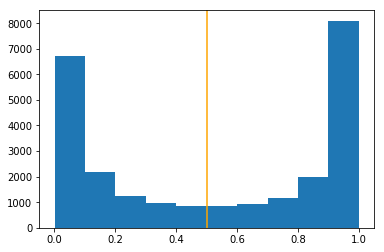

In [12]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [13]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'93.47'